In [19]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures


import sys

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')

# Years case

In [2]:
windows_map = read_ontario(granularity='years')
pollutans = ['NOx', 'O3']
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

/home/texs/anaconda3/envs/clearn/lib/python3.8/site-packages/numpy/lib/format.py:748: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  array = pickle.load(fp, **pickle_kwargs)


In [3]:
month_ids = [date.month for date in dates]
year_ids = [date.year for date in dates]


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, len(month_ids) + 1)}
years_map = {int(year) : str(year) for year in year_ids}

In [4]:
mts = TSerie(X=windows, y = station_ids)

mts.smooth(window_size=50)
mts.shapeNormalizization()

# mts.minMaxNormalizization()


Loaded mts - N: 202, T: 365, D: 2 
(202, 2, 365)


In [5]:
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'shape' # subsequences - shape
EPOCHS = 150
BATCH_SIZE = 32
ENC_SIZE = 8
mts.features = getContrastiveFeatures(
    mts.X.transpose([0, 2, 1]), mts.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    encoding_size = ENC_SIZE,
    conv_filters = [16, 32, 32], 
    conv_kernels = [7, 7, 7],
)

Epoch[1] Train loss    avg: 5.551804338182722

Epoch[10] Train loss    avg: 1.9338140147072929

Epoch[20] Train loss    avg: 1.5026400940758842

Epoch[30] Train loss    avg: 1.414050851549421

Epoch[40] Train loss    avg: 1.359537993158613

Epoch[50] Train loss    avg: 1.3029107877186366

Epoch[60] Train loss    avg: 1.289272427558899

Epoch[70] Train loss    avg: 1.2727998154503959

Epoch[80] Train loss    avg: 1.2711630378450667

Epoch[90] Train loss    avg: 1.2250014543533325

Epoch[100] Train loss    avg: 1.244105407169887

Epoch[110] Train loss    avg: 1.207645058631897

Epoch[120] Train loss    avg: 1.2168596812656947

Epoch[130] Train loss    avg: 1.217539974621364

Epoch[140] Train loss    avg: 1.196081485067095

Epoch[150] Train loss    avg: 1.2005981717790877

In [8]:
import umap

reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15)
coords = reducer.fit_transform(mts.features)

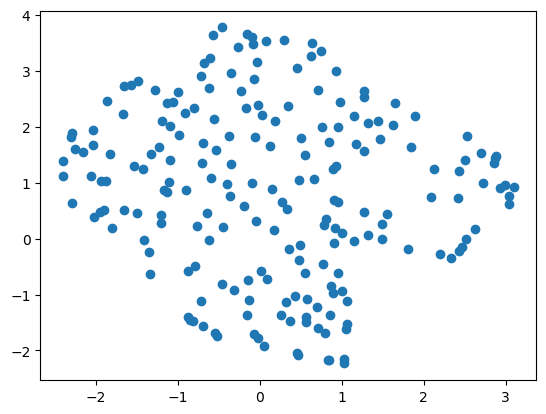

In [9]:
import matplotlib.pyplot as plt
plt.scatter(coords[:, 0], coords[:, 1])

In [10]:
import sys
sys.path.append('/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

storage = MTSStorage('mts_test')    
# storage.delete()
storage.load()

dimensions = pollutans
# dimensions = [sPoll, sPoll + '_norm']
# dimensions = pollutants + [poll + '_norm' for poll in pollutants]
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    'Test' , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        # 'shape': coords,
        # 'magnitude': coords_mean,
        'coords': coords,
    }
)



storage.save()

mts shape: N: 202 -  T: 365 - D: 4


# Months case

In [48]:
windows_map = read_ontario(granularity='months')
pollutans = ['NOx']
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [49]:
windows.shape

(4180, 28, 1)

In [50]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [51]:
mts = TSerie(X=windows, y = station_ids)

mts.smooth(window_size=8)

mts.shapeNormalizization()

# mts.minMaxNormalizization()

Loaded mts - N: 4180, T: 28, D: 1 
(4180, 1, 28)


In [52]:
# LOSS = 'SupConLoss' # SupConLoss | SimCLR
# MODE = 'shape' # subsequences - shape
# EPOCHS = 31
# BATCH_SIZE = 32
# ENC_SIZE = 8
# mts.features = getContrastiveFeatures(
#     mts.X.transpose([0, 2, 1]), mts.y, 
#     epochs = 100, 
#     batch_size = BATCH_SIZE, 
#     loss_metric= LOSS, 
#     mode = MODE, 
#     encoding_size = ENC_SIZE,
#     conv_filters = [16, 32, 32], 
#     conv_kernels = [7, 7, 7]
# )

from ts2vec import TS2Vec

# Train a TS2Vec model
model = TS2Vec(
    input_dims=mts.D,
    device=0,
    output_dims=16,
    batch_size = 64,
)
loss_log = model.fit(
    mts.X,
    verbose=True,
    n_epochs = 20,
)

mts.features = model.encode(mts.X, encoding_window='full_series')

Epoch #0: loss=2.550697292861354
Epoch #1: loss=2.5205324253359973
Epoch #2: loss=2.3630540101464224
Epoch #3: loss=1.9075772575034948
Epoch #4: loss=1.6517939763964364
Epoch #5: loss=1.5849342081281874
Epoch #6: loss=1.5646230114830866
Epoch #7: loss=1.5437919958797908
Epoch #8: loss=1.4745623439664586
Epoch #9: loss=1.4602642564024506
Epoch #10: loss=1.416308442294826
Epoch #11: loss=1.4391989262624718
Epoch #12: loss=1.4345768678690738
Epoch #13: loss=1.4235491533389037
Epoch #14: loss=1.413578834798601
Epoch #15: loss=1.4266299198870458
Epoch #16: loss=1.3913353295618547
Epoch #17: loss=1.3853192397917824
Epoch #18: loss=1.348861151956507
Epoch #19: loss=1.3434186173581528


In [53]:
# # print(mts.X[:2].shape)
# part1 = mts.X[:2]
# part2 = np.flip(mts.X[:2], 1).copy()
# # print(part1.shape)
# # print(part2.shape)
# # print(part1)
# # print(part2)
# test1 = model.encode(part1, encoding_window='full_series')
# test2 = model.encode(part2, encoding_window='full_series')
# print(test1)
# print(test2)
# # plt.plot()

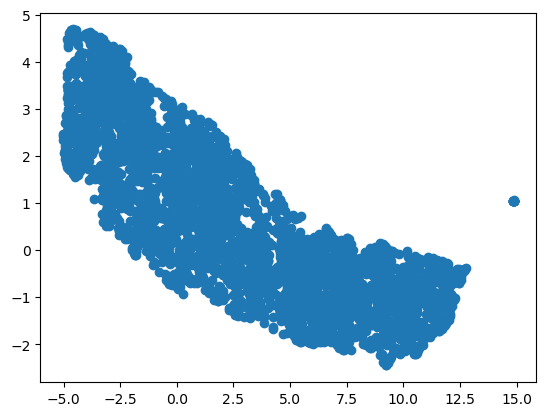

In [54]:
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15)
coords = reducer.fit_transform(mts.features)
plt.scatter(coords[:, 0], coords[:, 1])

In [56]:

storage = MTSStorage('mts_test')    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    'Test months' , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= 600
)

storage.save()

mts shape: N: 4180 -  T: 28 - D: 2
